### Trabajo Final Master Ciencia de Datos y Business Analytics
## Reporte Laboratorio Seco - Modelo de Predicción XGBoost
Septiembre 30, 2023

## Introducción
El siguiente cuaderno de laboratorio es el registro de la aplicación de un modelo XGBoost con el objetivo de encontrar el pronóstico adecuado a la data de POS de Sportline Colombia. 

## Lectura de Datos, Adecuación de las Variables, Feature Engineering
Para el entrenamiento de los datos, es importante leerlos del archivo de juegos de datos POS del datamart. En este caso en particular, se leen los datos extraidos para el _TFM_ correspondientes a las ventas de Sportline America Colombia del 1 de enero del 2018 al 30 de julio del 2023. 

In [1]:
# Importar y leer archivo como DF Pandas
# Los archivos se leen de los formatos por año ya limpios

import pandas as pd
csv_file_path = '/Users/ameilij/Documents/Master Data Science/MDS/tfm/data_clean/master_POS_SLA_COL_diario.csv'
encoding = 'latin1'
dfPOS = pd.read_csv(csv_file_path, encoding=encoding)
dfPOS.head()

,CODIGO_MARCA,FECHA,CANTIDAD,WEEK_OF_YEAR,YEAR,MONTH,XMAS
0,456.0,2018-01-02,892,2018-00,2018,January,0
1,456.0,2018-01-03,782,2018-00,2018,January,0
2,456.0,2018-01-04,1098,2018-00,2018,January,0
3,456.0,2018-01-05,1765,2018-00,2018,January,0
4,456.0,2018-01-06,2471,2018-00,2018,January,0


In [2]:
dfPOS['WEEK_OF_YEAR'] = pd.to_datetime(dfPOS['WEEK_OF_YEAR'] + '-0', format='%Y-%U-%w')
dfPOS['FECHA'] = pd.to_datetime(dfPOS['FECHA'], format= '%Y-%m-%d')
dfPOS['MONTH'] = dfPOS['WEEK_OF_YEAR'].dt.month
dfPOS['YEAR'] = dfPOS['WEEK_OF_YEAR'].dt.year
dfPOS['XMAS'] = ((dfPOS['MONTH'] >= 11) | (dfPOS['MONTH'] == 1)).astype(int)

start_date = pd.to_datetime('2020-03-01')
end_date = pd.to_datetime('2020-07-31')
dfPOS['COVID'] = ((dfPOS['WEEK_OF_YEAR'] >= start_date) & (dfPOS['WEEK_OF_YEAR'] <= end_date)).astype(int)

In [3]:
data_train = dfPOS[dfPOS['CODIGO_MARCA'] == 456]

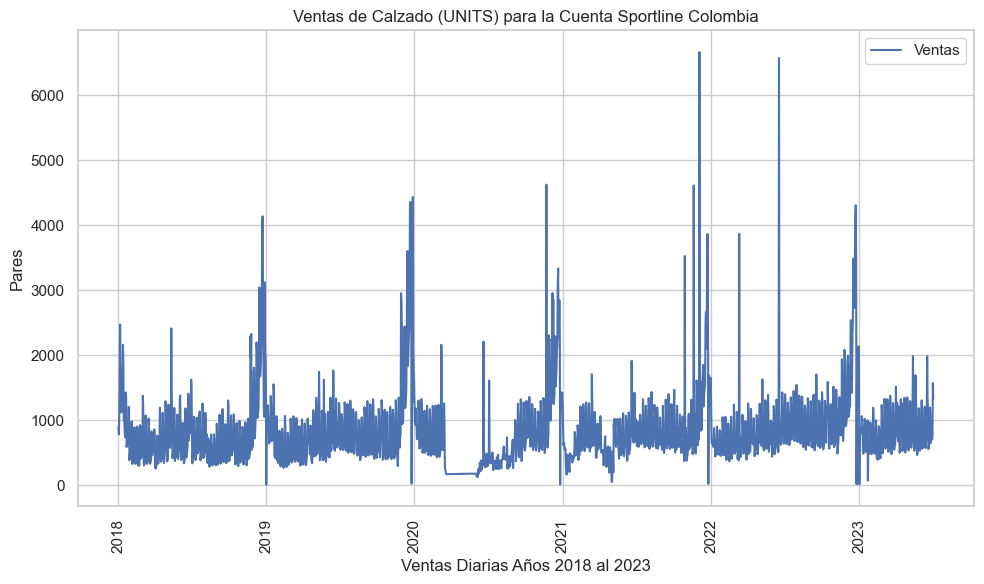

In [4]:
# Revisar la topologia de la serie de tiempos
import matplotlib.pyplot as plt
import seaborn as sns

# Agrupar la data por 'CODIGO_MARCA', y la semana del año
data_temp = data_train[['FECHA', 'CANTIDAD']].sort_values(by='FECHA', ascending=True)

sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
sns.lineplot(x='FECHA', y='CANTIDAD', data=data_temp, label='Ventas')
plt.title('Ventas de Calzado (UNITS) para la Cuenta Sportline Colombia')
plt.xlabel('Ventas Diarias Años 2018 al 2023')
plt.ylabel('Pares')
plt.xticks(rotation=90)
plt.tight_layout()
plt.legend()  # Add a legend to label the line

plt.show()

## Entrenamiento de Datos
Para el entrenamiento de datos se utilizó la librería `xgboost`. La libreria `xgboost` es una biblioteca optimizada de aumento de gradiente distribuido diseñada para ser altamente eficiente, flexible y portátil. Implementa algoritmos de aprendizaje automático bajo el marco de Gradient Boosting. XGBoost proporciona un impulso de árbol paralelo (también conocido como GBDT, GBM) que resuelve muchos problemas de ciencia de datos de forma rápida y precisa. El mismo código se ejecuta en los principales entornos distribuidos (Hadoop, SGE, MPI) y puede resolver problemas que van más allá de miles de millones de ejemplos.

Error cuadratico promedio: 204150.92998140486
Coeficiente Spearmann (R2): 0.3130860908403692


/var/folders/9c/f5lf7vz91zs8mwbnjbtxzjgw0000gn/T/ipykernel_2262/3744515811.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_train['DAYS_SINCE_START'] = (data_train['FECHA'] - min_date).dt.days


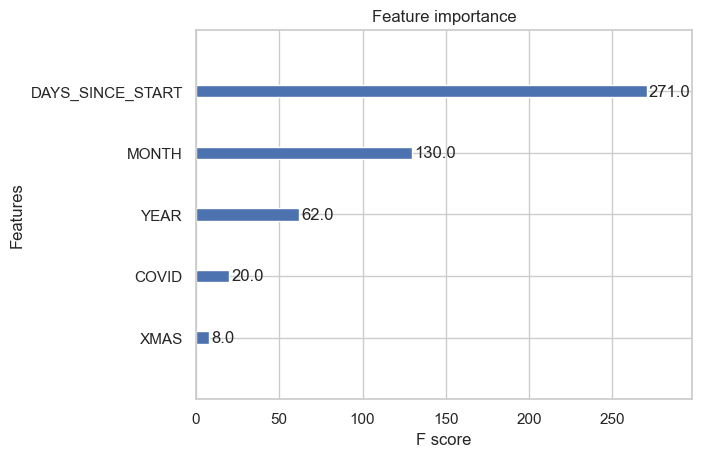

In [6]:
min_date = data_train['FECHA'].min()
data_train['DAYS_SINCE_START'] = (data_train['FECHA'] - min_date).dt.days

import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Definir data de entrenamiento, regresores y dividir entre juego de entrenamiento y test

X = data_train[['DAYS_SINCE_START', 'MONTH', 'YEAR', 'XMAS', 'COVID']]
y = data_train['CANTIDAD']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Crear modelo XGBoost
params = {
    'objective': 'reg:squarederror',  
    'random_state': 42,
    'learning_rate': 0.05,           
    'max_depth': 3,                 
    'n_estimators': 75,            
    'subsample': 0.8,               
    'colsample_bytree': 0.8,        
    'reg_alpha': 0.1,               
    'reg_lambda': 0.8               
}

model = xgb.XGBRegressor(**params)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Error cuadratico promedio: {mse}")
print(f"Coeficiente Spearmann (R2): {r2}")

xgb.plot_importance(model)
plt.show()

Los resultados del modelo nos muestra el valor F de cada regresor, ordenado por orden de importancia. 

* La distancia de la serie de tiempo (la variable `DAYS_SINCE_START`) es la más importante con un valor F de 271.0
* El mes de cada punto de dato tiene una importancia secundaria con un valor F de 130.0. Dado que se trata de una serie de tiempo, no es difícil entender porque, ya que en cierta forma las ventas tienen un patrón determinado por la importancia del mes para los compradores. 
* La tercera variable en orden de importancia es el año, con un valor F de 62.0

Llama mucho la atención que las variables para los puntos de datos en fechas de pandemia y temporada alta (`COVID` y `XMAS` respectivamente) no tienen mucha importancia en el modelo. 

En la gráfica siguiente se comparan los valores reales de la serie con los valores de predicción.

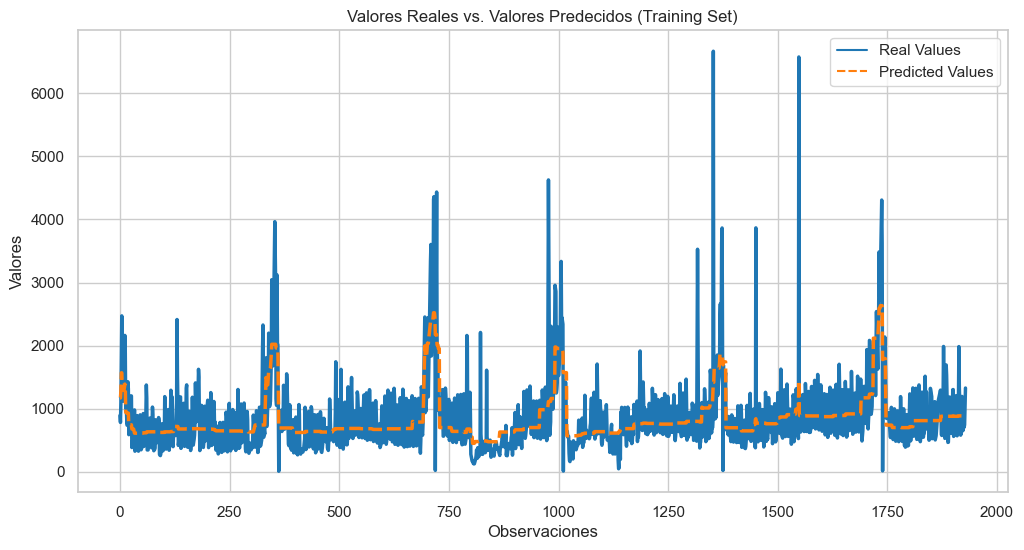

In [7]:
comparison_df = pd.DataFrame({'Real Values': y_train, 'Predicted Values': model.predict(X_train)})
sns.set(style="whitegrid")
plt.figure(figsize=(12, 6))
sns.lineplot(data=comparison_df, palette="tab10", linewidth=2.5)
plt.xlabel("Observaciones")
plt.ylabel("Valores")
plt.title("Valores Reales vs. Valores Predecidos (Training Set)")
plt.show()

Revisando los valores de predicción versus los valores reales, vemos que uno de los problemas es la falta de predicción en los meses de temporada alta de noviembre y diciembre (los que hemos identificado con la variable binaria _XMAS_). Sería interesante ver si podemos incrementar la atención del modelo XGBoost a estas ocurrencias en la data.

## Variación 1: Ajustando Pesos Relativos de los Regresores
Existe una manera de aumentar los pesos relativos de los regresores en XGBoost, para, como en nuestro caso, que el modelo interprete mejor la data de entrenamiento. En los siguientes pasos aumentamos el peso de los regresores cuando nos encontramos en época de temporada alta (la variable `XMAS` equivale 1) o en ajustamos en época de pandemia (la variable `COVID` equivale 1). 

Error cuadratico promedio: 205625.2295780114
Coeficiente Spearmann (R2): 0.308125462450042


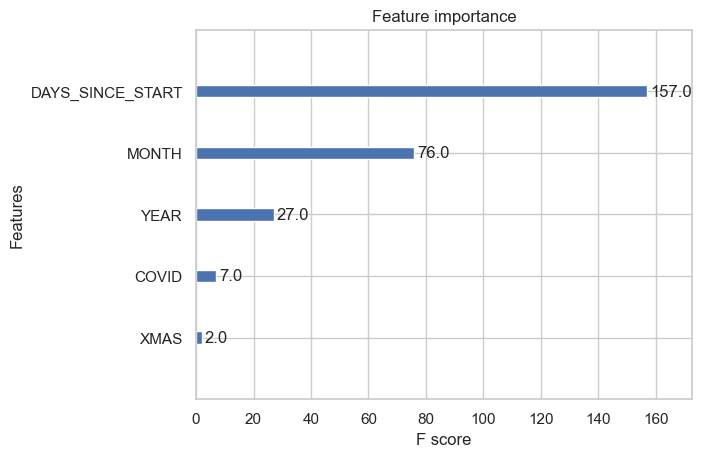

In [55]:
params_2 = {
    'objective': 'reg:squarederror',  
    'random_state': 42,
    'learning_rate': 0.1,           
    'max_depth': 2,                 
    'n_estimators': 90,            
    'subsample': 0.8,              
    'colsample_bytree': 0.8,       
    'reg_alpha': 0.1,              
    'reg_lambda': 0.1,             
    'min_child_weight': 1,         
    'gamma' : 0.1                  
}

weights = [1 if (xmas_value == 1 or covid_value == 1) 
          else 5.5 for xmas_value, covid_value in zip(X_train['XMAS'], X_train['COVID'])]

model_2 = xgb.XGBRegressor(**params_2)
model_2.fit(X_train, y_train, sample_weight=weights)

y_pred_2 = model_2.predict(X_test)
mse = mean_squared_error(y_test, y_pred_2)
r2 = r2_score(y_test, y_pred_2)

print(f"Error cuadratico promedio: {mse}")
print(f"Coeficiente Spearmann (R2): {r2}")

# Plot
xgb.plot_importance(model_2)
plt.show()

A pesar que hemos ajustados pesos, el modelo tiene muy poca variación, y los valores de error cuadrático y $R^2$ son casi iguales.

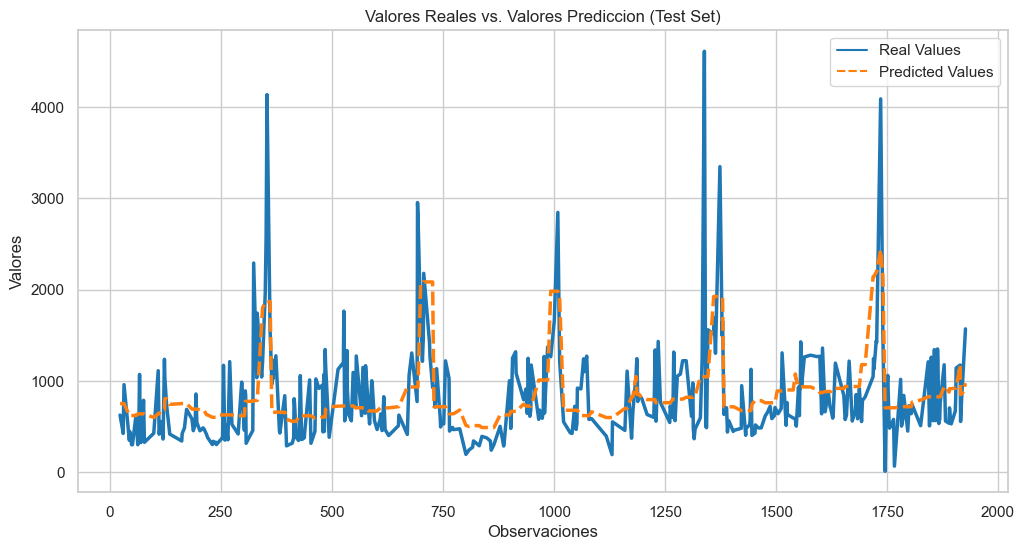

In [56]:
comparison_df = pd.DataFrame({'Real Values': y_test, 'Predicted Values': model_2.predict(X_test)})
sns.set(style="whitegrid")
plt.figure(figsize=(12, 6))
sns.lineplot(data=comparison_df, palette="tab10", linewidth=2.5)
plt.xlabel("Observaciones")
plt.ylabel("Valores")
plt.title("Valores Reales vs. Valores Prediccion (Test Set)")
plt.show()

Descartamos esta variante, ya que no refleja mejoras en el modelo.

## Variación 2: Agrupar la Data Semanalmente
Una hipótesis interesante para explorar es si el uso de data agrupada semanalmente mejorará el modelo versus la data diaria. La data agrupada semanalmente debe disminuir la varianza intrinseca de los diferentes días de ventas. 

In [105]:
csv_file_path = '/Users/ameilij/Documents/Master Data Science/MDS/tfm/data_clean/master_POS_SLA_COL_semanal.csv'
encoding = 'latin1'
dfPOS = pd.read_csv(csv_file_path, encoding=encoding)
dfPOS['WEEK_OF_YEAR'] = pd.to_datetime(dfPOS['WEEK_OF_YEAR'] + '-0', format='%Y-%U-%w')
dfPOS['MONTH'] = dfPOS['WEEK_OF_YEAR'].dt.month
dfPOS['YEAR'] = dfPOS['WEEK_OF_YEAR'].dt.year
dfPOS['XMAS'] = ((dfPOS['MONTH'] >= 11) | (dfPOS['MONTH'] == 1)).astype(int)

start_date = pd.to_datetime('2020-03-01')
end_date = pd.to_datetime('2020-07-31')
dfPOS['COVID'] = ((dfPOS['WEEK_OF_YEAR'] >= start_date) & (dfPOS['WEEK_OF_YEAR'] <= end_date)).astype(int)
data_train = dfPOS[dfPOS['CODIGO_MARCA'] == 456]

Error cuadratico promedio: 1534443.8619864574
Coeficiente Spearmann (R2): 0.7414631242443535


/var/folders/9c/f5lf7vz91zs8mwbnjbtxzjgw0000gn/T/ipykernel_2262/2275316260.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_train['WEEKS_SINCE_START'] = (data_train['WEEK_OF_YEAR'] - min_week).dt.days // 7


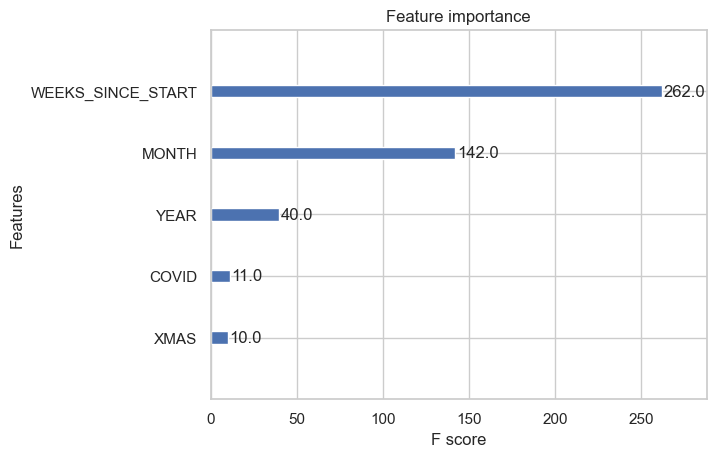

In [172]:
min_week = data_train['WEEK_OF_YEAR'].min()
data_train['WEEKS_SINCE_START'] = (data_train['WEEK_OF_YEAR'] - min_week).dt.days // 7

import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Definir data de entrenamiento, regresores y dividir entre juego de entrenamiento y test
X = data_train[['WEEKS_SINCE_START', 'MONTH', 'YEAR', 'XMAS', 'COVID']]
y = data_train['CANTIDAD']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Crear modelo XGBoost
weights = [50 if not (xmas_value == 1 or covid_value == 1) 
           else 1 for xmas_value, covid_value in zip(X_train['XMAS'], X_train['COVID'])]

# Crear modelo XGBoost
params_3 = {
    'objective': 'reg:squarederror',  
    'random_state': 42,
    'learning_rate': 0.2,           
    'max_depth': 6,                 
    'n_estimators': 50,            
    'subsample': 0.75,               
    'colsample_bytree': 0.35,        
    'reg_alpha': 0.1,               
    'reg_lambda': 0.1,               
    'min_child_weight': 1,          
    'gamma' : 0.1                   
}

model_3 = xgb.XGBRegressor(**params_3)
model_3.fit(X_train, y_train, sample_weight=weights)

y_pred_3 = model_3.predict(X_test)
mse = mean_squared_error(y_test, y_pred_3)
r2 = r2_score(y_test, y_pred_3)

print(f"Error cuadratico promedio: {mse}")
print(f"Coeficiente Spearmann (R2): {r2}")

# Plot
xgb.plot_importance(model_3)
plt.show()

Este modelo parece reducir la importancia de la distancia en semanas de la serie de tiempo, y le otorga al mes mucho más peso que al año. Inclusive el valor relativo de la variable `COVID` y `XMAS` ha aumentado. ¿Puede el modelo modelar mejor la data de entrenamiento que el modelo diario?

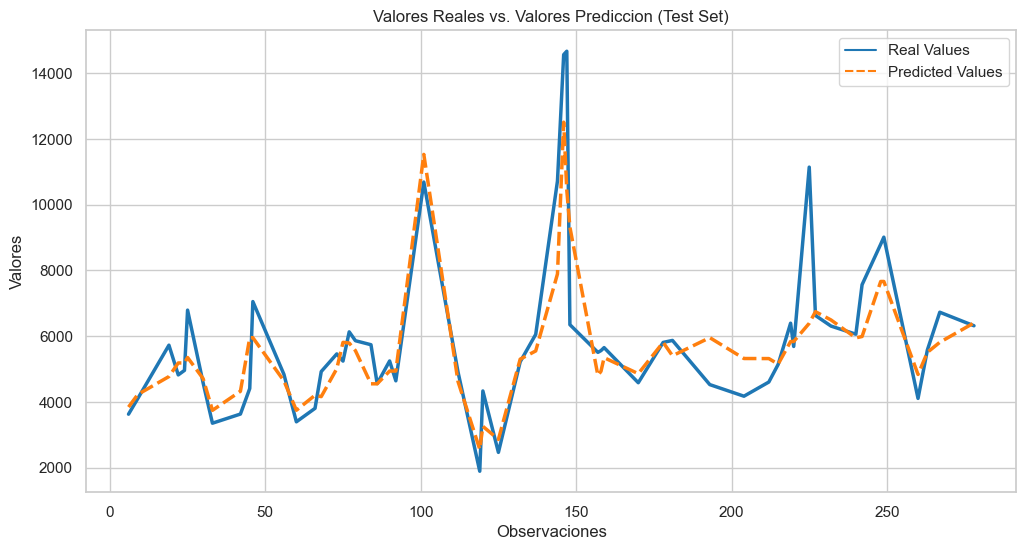

In [175]:
comparison_df = pd.DataFrame({'Real Values': y_test, 'Predicted Values': y_pred_3})
sns.set(style="whitegrid")
plt.figure(figsize=(12, 6))
sns.lineplot(data=comparison_df, palette="tab10", linewidth=2.5)
plt.xlabel("Observaciones")
plt.ylabel("Valores")
plt.title("Valores Reales vs. Valores Prediccion (Test Set)")
plt.show()

El modelo _XGBOOST_ utilizando data agrupada semanalmente promete ser un modelo con gran capacidad de estimación, y se convierte en el modelo con mejor $R^2$ de todos los evaluados hasta ahora. 

|                   |   RMSE     |     R2    |
|-------------------|:----------:|:---------:|
| Regresión Lineal  | 243568.12  |  0.18     |
| Polinomio 4 Grado | 181688.81  |  0.39     |
| Arima (5,1,2)     | 169561.47  |  0.53     |
| XGBoost (Semanal) | 1534443.86 |  0.74     |


## Conclusiones
El modelo XGBoost arrojó mejores resultados que el modelo de regresión, el modelo polinómico de cuarto grado o el modelo ARIMA. Pero aún así, los resultados están lejos de ser los esperados. Con un valor R2 de 0.74, el modelo tiene valor predictivo mediano pero está lejos de ser óptimo para entrar en producción. Sin embargo es el primero de todos los modelos revisados que muestra señales de éxito si se ahondan más pruebas. 